In [1]:
import pandas as pd
from sqlalchemy import create_engine, inspect, types
from sqlalchemy.dialects.postgresql import insert
import os
from pathlib import Path
from dotenv import load_dotenv

base_dir = Path.cwd().parent
env_file = base_dir / '.env'
load_dotenv(env_file)
db_user = os.getenv("POSTGRES_USER")
db_pass = os.getenv("POSTGRES_PASSWORD")
db_host = "localhost"
db_name = os.getenv("POSTGRES_DB")

DB_CONN_STR = f"postgresql+psycopg2://{db_user}:{db_pass}@{db_host}:5432/{db_name}"

engine = create_engine(DB_CONN_STR)


In [2]:
def single_station_load(engine, station_id):
    query = "SELECT * FROM clean_station_data WHERE station_id=%(sid)s"
    params = {'sid': station_id}
    df_out = pd.read_sql(query, engine, params=params)
    return df_out

df_haifa = single_station_load(engine, 43)
df_tel_aviv = single_station_load(engine, 178)
df_afula = single_station_load(engine, 16)
df_afula.head()

,timestamp,rain,wsmax,wdmax,ws,stdwd,td,rh,tdmax,tdmin,ws1mm,ws10mm,u_vec,v_vec,rain_intensity_max,station_id,latitude,longitude
0,2019-12-31 22:00:00,0.0,1.4,322.0,0.666667,13.300000,8.833333,91.333333,9.5,8.1,1.3,1.2,0.312851,-0.347125,0.0,16,32.596,35.2769
1,2019-12-31 23:00:00,0.0,1.5,276.0,0.866667,11.416667,7.783333,97.166667,8.2,7.1,1.3,1.2,0.852835,0.133639,0.0,16,32.596,35.2769
2,2020-01-01 00:00:00,0.0,1.8,290.0,1.033333,13.050000,6.883333,99.833333,7.3,6.2,1.7,1.3,0.992793,0.091221,0.0,16,32.596,35.2769
3,2020-01-01 01:00:00,0.0,1.8,352.0,0.616667,24.750000,6.000000,100.000000,6.5,5.5,1.6,1.2,0.318678,0.120158,0.0,16,32.596,35.2769
4,2020-01-01 02:00:00,0.0,1.8,229.0,0.916667,14.600000,5.783333,100.000000,6.2,5.5,1.6,1.4,0.383916,0.733935,0.0,16,32.596,35.2769


In [3]:
print(df_afula.shape)
print(df_afula.columns.tolist())

(43848, 18)
['timestamp', 'rain', 'wsmax', 'wdmax', 'ws', 'stdwd', 'td', 'rh', 'tdmax', 'tdmin', 'ws1mm', 'ws10mm', 'u_vec', 'v_vec', 'rain_intensity_max', 'station_id', 'latitude', 'longitude']


In [4]:
def sort_by_ts(df: pd.DataFrame):
    df.set_index('timestamp', inplace=True)
    df.sort_index(axis=0, ascending=True, inplace=True)

sort_by_ts(df_afula)
sort_by_ts(df_tel_aviv)
sort_by_ts(df_haifa)

## Feature engineering functions (timelags/upstream)

In [5]:
def create_local_lags(df: pd.DataFrame, lag_hours=[1, 2, 3, 6, 12, 24]):
    """
    Creates autoregressive lag features for a single station's dataframe.
    Assumes df is already filtered for ONE station and sorted by time.
    """
    df_out = df.copy()
    target_cols = ['rain', 'u_vec', 'v_vec', 'td', 'rh', 'rain_intensity_max']

    for col in target_cols:
        if col in df_out.columns:
            for h in lag_hours:
                feat_name = f"{col}_t-{h}h"
                df_out[feat_name] = df_out[col].shift(h)


    df_out['target_rain_t+1'] = df_out['rain'].shift(-1)
    return df_out

In [6]:
def add_upstream_features(df_target: pd.DataFrame, df_upstream: pd.DataFrame, upstream_name, lag_hours=[1, 2, 3], join_type='inner'):
    """
    Joins upstream station data onto the target station.
    """
    force_cols = ['rain', 'u_vec', 'v_vec']
    renamed_cols = {c: f"{c}_{upstream_name}" for c in force_cols}
    df_force = df_upstream[force_cols].rename(columns=renamed_cols).copy()
    
    for col, new_name in renamed_cols.items():
        for h in lag_hours:
            df_force[f"{new_name}_t-{h}h"] = df_force[new_name].shift(h)

    df_merged = df_target.join(df_force, how=join_type)
    
    return df_merged

## Data splitting with time-series preservation

In [7]:
def temporal_split(df: pd.DataFrame, target_col, val_start_date, test_start_date):
    """
    Splits time-series data into training/validation/testing sets
    
    :param df: Pandas DataFrame
    :param val_start_date: String representation 'yyyy-mm-dd'
    :param test_start_date: String representation 'yyyy-mm-dd'

    Returns:
        SplitDataFrames: X_train, X_val, X_test, y_train, y_val, y_test
    """
    feature_cols = [c for c in df.columns if c != target_col]
    X = df[feature_cols]
    y = df[target_col]

    X_train = X[X.index < val_start_date]
    y_train = y[y.index < val_start_date]

    mask_val = (X.index >= val_start_date) & (X.index < test_start_date)
    X_val = X[mask_val]
    y_val = y[mask_val]

    X_test = X[X.index >= test_start_date]
    y_test = y[y.index >= test_start_date]

    return X_train, X_val, X_test, y_train, y_val, y_test


**Constructing DataFrames**

In [8]:
df_afula_lags = create_local_lags(df_afula).dropna()

df_afula_lags_upstream_TA = add_upstream_features(
    df_afula_lags,
    df_tel_aviv,
    upstream_name="tel_aviv",
    join_type='left'
)

df_afula_lags_upstream_TA_HA = add_upstream_features(
    df_afula_lags_upstream_TA,
    df_haifa,
    upstream_name="haifa",
    join_type='left'
)

## XGBoost no feature engineering

In [9]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error

val_start_date = '2023-01-01'
test_start_date = '2024-01-01'

X_train, X_val, X_test, y_train, y_val, y_test = temporal_split(
    df_afula_lags,
    'target_rain_t+1',
    val_start_date,
    test_start_date
)

basic_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    objective='reg:squarederror',
    n_jobs=-1,
    early_stopping_rounds=50
)

basic_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

preds_test = basic_model.predict(X_test)

## XGBoost with upstream features and feature engineering

With telaviv only

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test = temporal_split(
    df_afula_lags_upstream_TA,
    'target_rain_t+1',
    val_start_date,
    test_start_date
)

boosted_model1 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    objective='reg:squarederror',
    n_jobs=-1,
    early_stopping_rounds=50,
    missing=np.nan,
    monotone_constraints={"rain_tel_aviv": 1}
)

boosted_model1.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

preds_test_boosted1 = boosted_model1.predict(X_test)

With haifa and telaviv

In [11]:
X_train, X_val, X_test, y_train, y_val, y_test = temporal_split(
    df_afula_lags_upstream_TA_HA,
    'target_rain_t+1',
    val_start_date,
    test_start_date
)

boosted_model2 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    objective='reg:squarederror',
    n_jobs=-1,
    early_stopping_rounds=50,
    missing=np.nan,
    monotone_constraints={"rain_tel_aviv": 1, "rain_haifa": 1}
)

boosted_model2.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

preds_test_boosted2 = boosted_model2.predict(X_test)

**BASELINE 0 Complexity Model**

In [12]:
preds_presistence = X_test['rain']

Conditional RMSE

In [13]:
def storm_rmse(y_pred, y_test, model_name):
    mask_rainy = y_test > 0.1

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(model_name + ':')
    print(f"GLOBAL t+1 RMSE: {rmse:.4f} mm")

    if mask_rainy.sum() > 0:
        y_rainy = y_test[mask_rainy]
        pred_rainy = y_pred[mask_rainy]
        rmse_rainy = np.sqrt(mean_squared_error(y_rainy, pred_rainy))
        print(f"Storm-Only t+1 RMSE: {rmse_rainy:.4f} mm")
        print()
    else:
        print("No rain events in the test set!")


# On our baseline presistence model
storm_rmse(preds_presistence, y_test, 'Baseline Persistence')

# On our baseline XGBoost
storm_rmse(preds_test, y_test, 'Baseline XGBoost')

# On our XGBoost with upstream from Telaviv
storm_rmse(preds_test_boosted1, y_test, 'XGBoost upstream Telaviv')

# On our XGBoost with upstream from Telaviv and Haifa
storm_rmse(preds_test_boosted2, y_test, 'XGBoost upstream Telaviv Haifa')

Baseline Persistence:
GLOBAL t+1 RMSE: 0.6767 mm
Storm-Only t+1 RMSE: 2.7457 mm

Baseline XGBoost:
GLOBAL t+1 RMSE: 0.5588 mm
Storm-Only t+1 RMSE: 2.3578 mm

XGBoost upstream Telaviv:
GLOBAL t+1 RMSE: 0.5443 mm
Storm-Only t+1 RMSE: 2.3016 mm

XGBoost upstream Telaviv Haifa:
GLOBAL t+1 RMSE: 0.5266 mm
Storm-Only t+1 RMSE: 2.2025 mm



## Plotting feature importances and impacts

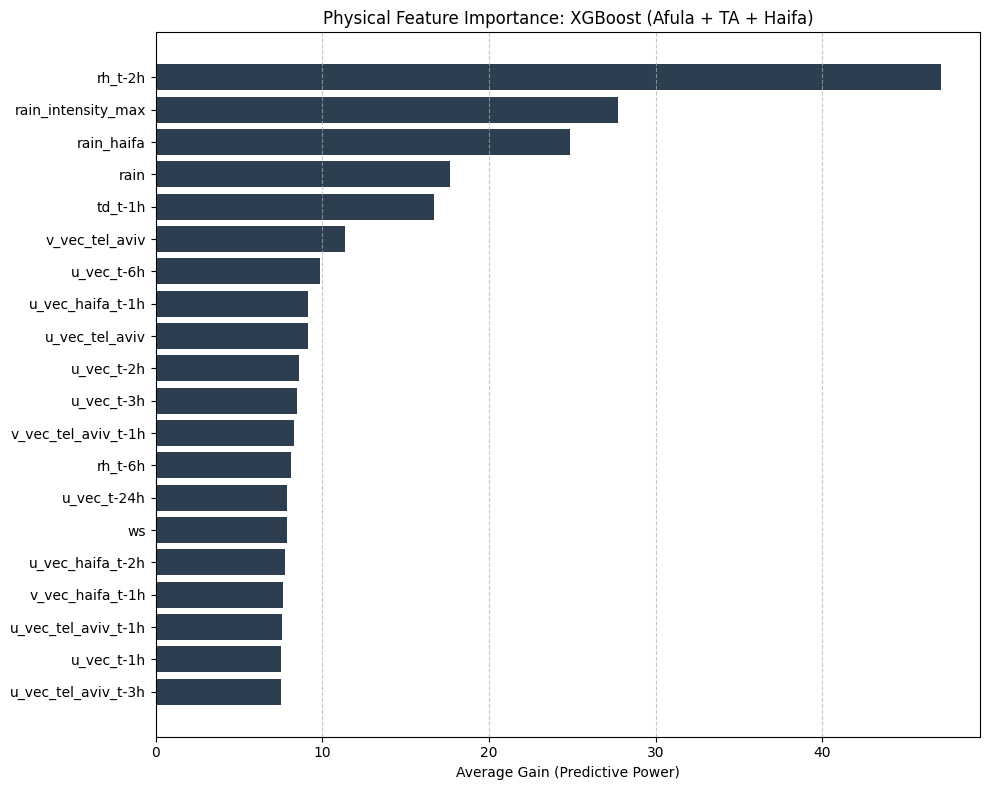

In [14]:
import matplotlib.pyplot as plt

def plot_physical_importance(model, model_name):
    # 'gain' = Average improvement in accuracy brought by a feature
    importance = model.get_booster().get_score(importance_type='gain')
    
    # Sort and take top 20 for readability
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:20]
    
    features, scores = zip(*sorted_importance)
    
    plt.figure(figsize=(10, 8))
    plt.barh(features, scores, color='#2c3e50')
    plt.xlabel('Average Gain (Predictive Power)')
    plt.title(f'Physical Feature Importance: {model_name}')
    plt.gca().invert_yaxis()  # Highest importance at top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run on your final spatial model
plot_physical_importance(boosted_model2, "XGBoost (Afula + TA + Haifa)")